# Equipament Maintenance Prediction

In [12]:
import mlflow
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm

from imblearn.over_sampling import SMOTE
from pathlib import Path
from scipy import stats
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from xgboost import XGBClassifier

In [13]:
ROOT_PATH = Path(__name__).resolve().parent.parent
data_folder_path = os.path.join(ROOT_PATH, "data")

data_path = os.path.join(data_folder_path, "equipament-cycles.csv")

In [14]:
data = pd.read_csv(data_path, header=0, sep=",")

data.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [15]:
data.loc[data["Machine failure"] == 1]

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
50,51,L47230,L,298.9,309.1,2861,4.6,143,1,0,0,1,0,0
69,70,L47249,L,298.9,309.0,1410,65.7,191,1,0,0,1,1,0
77,78,L47257,L,298.8,308.9,1455,41.3,208,1,1,0,0,0,0
160,161,L47340,L,298.4,308.2,1282,60.7,216,1,0,0,0,1,0
161,162,L47341,L,298.3,308.1,1412,52.3,218,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9758,9759,L56938,L,298.6,309.8,2271,16.2,218,1,1,0,0,0,0
9764,9765,L56944,L,298.5,309.5,1294,66.7,12,1,0,0,1,0,0
9822,9823,L57002,L,298.5,309.4,1360,60.9,187,1,0,0,0,1,0
9830,9831,L57010,L,298.3,309.3,1337,56.1,206,1,0,0,0,1,0


In [16]:
data.isnull().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

In [17]:
data.dtypes

UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object

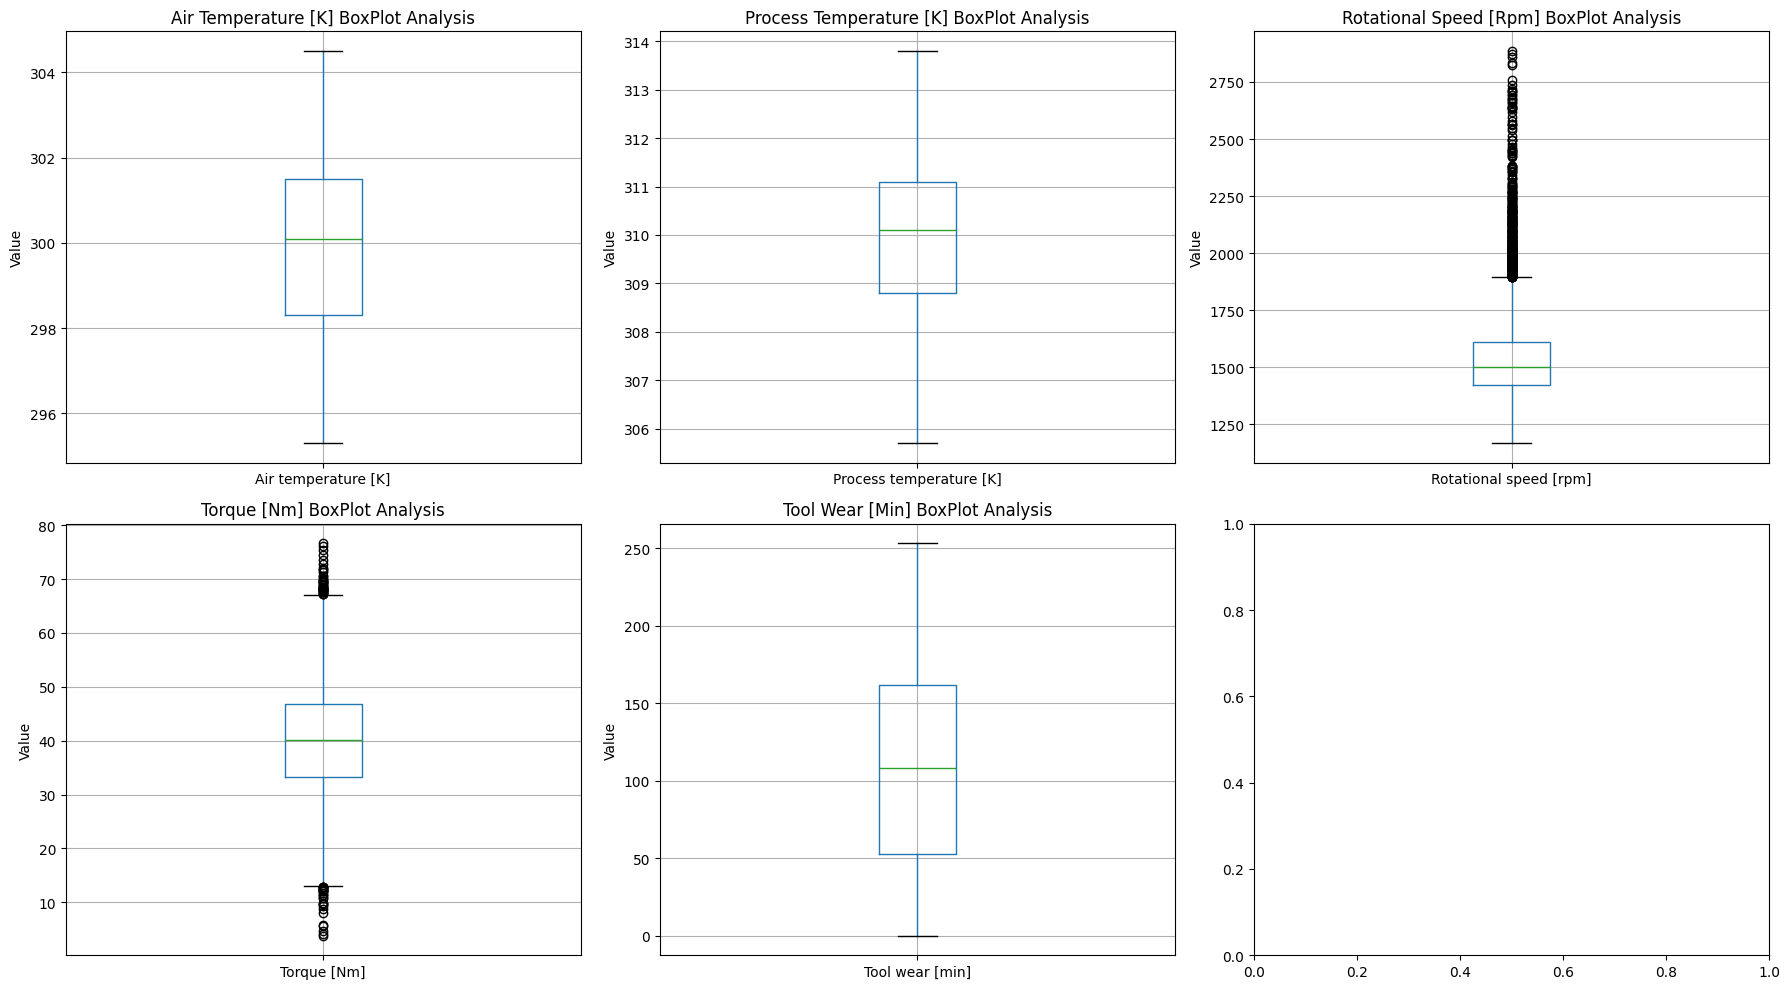

In [18]:
cols_drop = ["UDI", "Product ID", "Type", "Machine failure", "TWF", "HDF", "PWF", "OSF", "RNF"]
temp = data.drop(cols_drop, axis=1)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(temp.columns):
    ax = axes[i]
    temp.boxplot(column=col, ax=ax)
    ax.set_title(f"{col.title()} BoxPlot Analysis")
    ax.set_ylabel("Value")

plt.tight_layout()
plt.show();

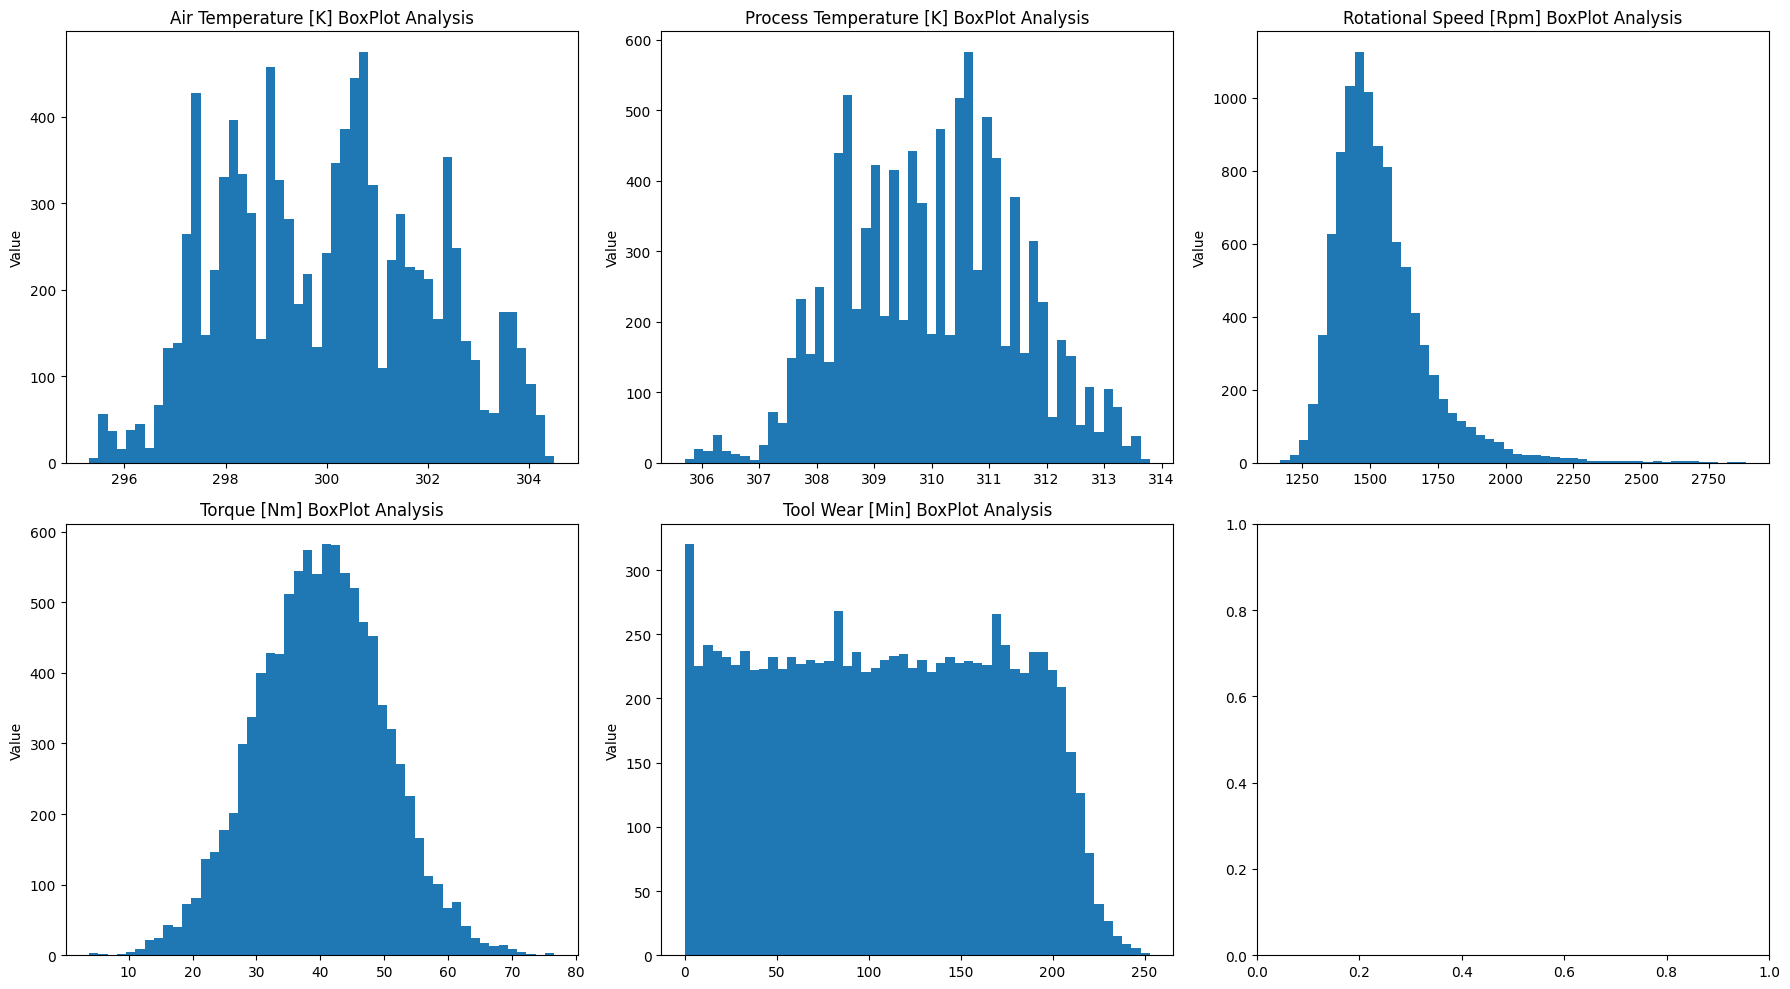

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(temp.columns):
    ax = axes[i]
    temp.hist(column=col, ax=ax, grid=False, bins=50)
    ax.set_title(f"{col.title()} BoxPlot Analysis")
    ax.set_ylabel("Value")

plt.tight_layout()
plt.show();

If the machine goes further than the top quantile, does it generate more failure?

H0 -> Rotation on outlier parameters does not have impact<br>
H1 -> Rotation on outlier parameters does have impact

In [20]:
q1 = data["Rotational speed [rpm]"].quantile(0.25)
q3 = data["Rotational speed [rpm]"].quantile(0.75)

iqr = q3 - q1
superior_limit = q3 + 1.5 * iqr

In [21]:
couting_over_limit = data.loc[data["Rotational speed [rpm]"]>=superior_limit]["Machine failure"].value_counts()
couting_under_limit = data.loc[data["Rotational speed [rpm]"]<superior_limit]["Machine failure"].value_counts()

In [22]:
chance_of_failure_above_limit = (
    couting_over_limit[1] / couting_over_limit.sum()
    ) * 100

In [23]:
chance_of_failure_under_limit = (
    couting_under_limit[1] / couting_under_limit.sum()
    ) * 100

In [24]:
print(f"Above Limit: {chance_of_failure_above_limit.round(2)} %")
print(f"Under Limit: {chance_of_failure_under_limit.round(2)} %")

Above Limit: 8.37 %
Under Limit: 3.17 %


Although we have a higher chance of failure with the equipament running up to the outliers values, it's not conclusive that it generate a failure.<br>
To really understand the impact of rotation on failure, we would have to take a look at the equipament manual and evaluate its operations limits.<br>

Types of procuts manufactured

In [25]:
print(f"Products: {data["Type"].unique()}\n")
print(f"Counting: {data["Type"].value_counts()}")

Products: ['M' 'L' 'H']

Counting: Type
L    6000
M    2997
H    1003
Name: count, dtype: int64


In [26]:
resume_failure = data.loc[data["Machine failure"]==1]
resume_type = resume_failure.groupby(["Type"]).agg({"Machine failure": "count"}).reset_index()

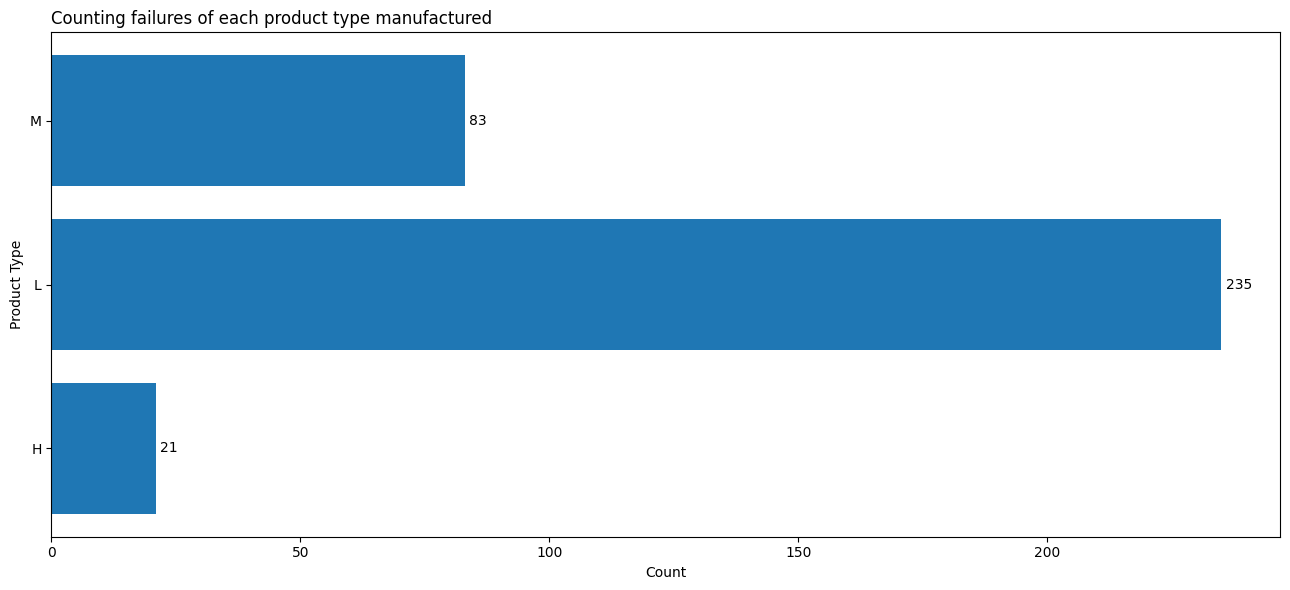

In [27]:
fig, ax = plt.subplots(figsize=(13, 6))

bars = ax.barh(width=resume_type["Machine failure"], y=resume_type["Type"])
ax.set_ylabel("Product Type")
ax.set_xlabel("Count")
ax.set_title("Counting failures of each product type manufactured", loc="left")
ax.bar_label(bars, padding=3)
plt.tight_layout()
plt.show()

Checking normalization on the variables

In [28]:
data

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,0,0,0,0,0
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,0,0,0,0,0
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,0,0,0,0,0
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,0,0,0,0,0


In [29]:
cols_to_transform = list()

for col in data.drop(cols_drop, axis=1).columns:

    test = stats.normaltest(data[col])
    pvalue = test.pvalue

    alpha = 0.05
    
    if pvalue > alpha:
        print(f"column: {col}  /  p-value: {pvalue}")
        print('Não rejeita H0: Os dados parecem ser normalmente distribuídos.\n')
    else:
        cols_to_transform.append(col)
        print(f"column: {col}  /  p-value: {pvalue}")
        print('Rejeita H0: Os dados não seguem uma distribuição normal.\n')


column: Air temperature [K]  /  p-value: 1.0072499825465616e-223
Rejeita H0: Os dados não seguem uma distribuição normal.

column: Process temperature [K]  /  p-value: 2.929128551005999e-42
Rejeita H0: Os dados não seguem uma distribuição normal.

column: Rotational speed [rpm]  /  p-value: 0.0
Rejeita H0: Os dados não seguem uma distribuição normal.

column: Torque [Nm]  /  p-value: 0.8991516896381265
Não rejeita H0: Os dados parecem ser normalmente distribuídos.

column: Tool wear [min]  /  p-value: 0.0
Rejeita H0: Os dados não seguem uma distribuição normal.



In [30]:
data_transformed = data.copy()

for col in cols_to_transform:
    data_array = np.array(data[col]).reshape(-1, 1)
    transformer = PowerTransformer(method="yeo-johnson")
    data_transformed[f"{col}_t"] = transformer.fit_transform(data_array).flatten()
    
    data_transformed.drop(col, axis=1, inplace=True)

Later, I'll try both ways and understand which fits better. Normalized data or original data

The structure of the modeling may include a failure prediction before the the failure itself.<br>

To do that, we can get the value of failure and offset it to the previous cycles, creating the possibility of early prediction before failure X cycles before real failure.<br>
<br>
We'll try to make the prediction in a range of 3 cycles before failure

In [31]:
data_new = data.drop([col for col in cols_drop if col != "Machine failure" and col != "Type"], axis=1).copy()

In [32]:
for i in data_new.index:
    status = data_new.loc[i, "Machine failure"]
    if status == 1 and i > 3:
        data_new.loc[i-1, "Machine failure"] = 1
        data_new.loc[i-2, "Machine failure"] = 1
        data_new.loc[i-3, "Machine failure"] = 1    

In [33]:
data_new["Machine failure"].value_counts()

Machine failure
0    8811
1    1189
Name: count, dtype: int64

In [34]:
non_failure = data_new["Machine failure"].value_counts()[0]
failure = data_new["Machine failure"].value_counts()[1]

diff = (failure / non_failure) -1

cutting = 0.2

if abs(diff) > cutting:
    print(f"Difference {diff.round(3) * 100}%\n")
    print("Data is unbalanced. Treatment of balancing is required.")
else:
    print(f"Difference {diff.round(3) * 100}\n")
    print("Data is balanced. No treatment needed")

Difference -86.5%

Data is unbalanced. Treatment of balancing is required.


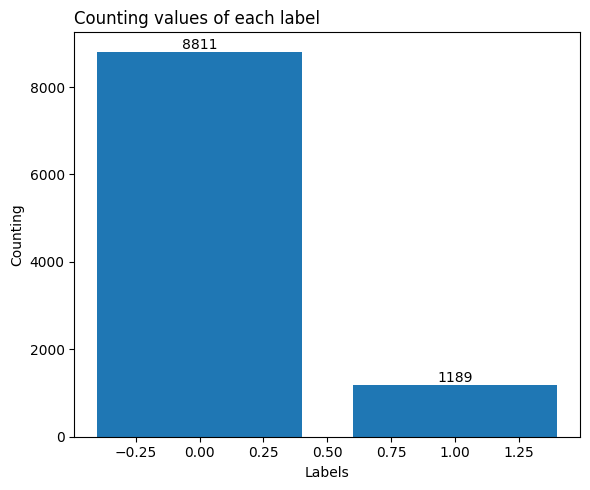

In [35]:
fig, ax = plt.subplots(figsize=(6, 5))

counting = data_new.groupby(["Machine failure"]).agg({"Type": "count"}).reset_index()

bars = ax.bar(height=counting["Type"], x=counting["Machine failure"])
ax.bar_label(bars)
ax.set_xlabel("Labels")
ax.set_ylabel("Counting")
ax.set_title("Counting values of each label", loc="left")
plt.tight_layout()
plt.show();

### Balancing data

In [36]:
X = data_new.drop(["Machine failure"], axis=1)
y = data_new.loc[:, "Machine failure"]

We've got important variable called Type. Although, this variable is a categorical value.<br>
<br>
As soons as I may use this variable, I'll convert it to binary values with the One-Hot-Encoding method

In [37]:
X = pd.get_dummies(X, columns=["Type"], dtype=int)

# I'll not drop de first dummy. I'll keep all of them

In [38]:
smote = SMOTE()
X_b, y_b = smote.fit_resample(X, y)

data_balanced = pd.concat([X_b, y_b], axis=1)

In [39]:
data_balanced

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Type_H,Type_L,Type_M,Machine failure
0,298.100000,308.600000,1551,42.800000,0,0,0,1,0
1,298.200000,308.700000,1408,46.300000,3,0,1,0,0
2,298.100000,308.500000,1498,49.400000,5,0,1,0,0
3,298.200000,308.600000,1433,39.500000,7,0,1,0,0
4,298.200000,308.700000,1408,40.000000,9,0,1,0,0
...,...,...,...,...,...,...,...,...,...
17617,303.008211,311.232457,1335,52.584413,172,0,0,0,1
17618,300.323094,310.824924,1417,47.048628,194,1,0,0,1
17619,301.734533,310.509095,1621,33.410943,96,0,0,1,1
17620,300.220862,310.571767,1685,28.779138,210,0,0,0,1


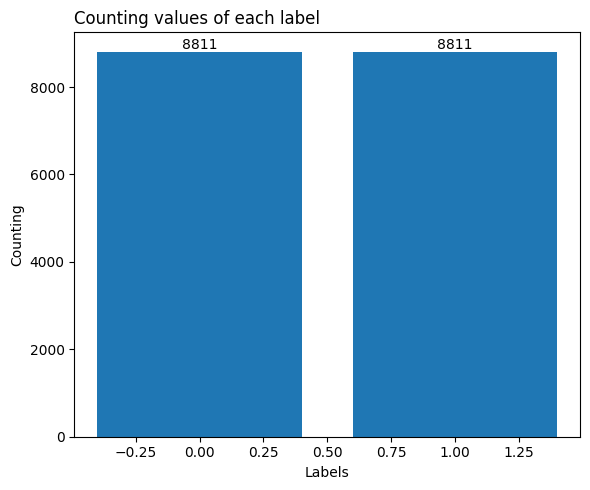

In [40]:
fig, ax = plt.subplots(figsize=(6, 5))

counting = data_balanced.groupby(["Machine failure"]).agg({"Type_H": "count"}).reset_index()

bars = ax.bar(height=counting["Type_H"], x=counting["Machine failure"])
ax.bar_label(bars)
ax.set_xlabel("Labels")
ax.set_ylabel("Counting")
ax.set_title("Counting values of each label", loc="left")
plt.tight_layout()
plt.show();

In [41]:
data_balanced.corr(method="pearson")

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Type_H,Type_L,Type_M,Machine failure
Air temperature [K],1.000000,0.861004,0.003576,0.003831,-0.053451,-0.041661,-0.041413,-0.050491,0.241153
Process temperature [K],0.861004,1.000000,0.018530,-0.012508,-0.008868,-0.022664,-0.025341,-0.015011,0.107309
Rotational speed [rpm],0.003576,0.018530,1.000000,-0.862153,-0.031430,-0.002948,-0.007022,0.018452,0.000151
Torque [Nm],0.003831,-0.012508,-0.862153,1.000000,0.018996,-0.018533,0.012010,-0.032516,0.087964
Tool wear [min],-0.053451,-0.008868,-0.031430,0.018996,1.000000,-0.053071,-0.025118,-0.069227,0.262231
Type_H,-0.041661,-0.022664,-0.002948,-0.018533,-0.053071,1.000000,-0.267365,-0.134916,-0.132514
Type_L,-0.041413,-0.025341,-0.007022,0.012010,-0.025118,-0.267365,1.000000,-0.510027,-0.190446
Type_M,-0.050491,-0.015011,0.018452,-0.032516,-0.069227,-0.134916,-0.510027,1.000000,-0.244022
Machine failure,0.241153,0.107309,0.000151,0.087964,0.262231,-0.132514,-0.190446,-0.244022,1.000000


In [42]:
data_balanced.corr(method="kendall")

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Type_H,Type_L,Type_M,Machine failure
Air temperature [K],1.000000,0.654576,-0.007448,0.005880,-0.040549,-0.034652,-0.034250,-0.042231,0.202777
Process temperature [K],0.654576,1.000000,0.008119,-0.006954,-0.009101,-0.019351,-0.021663,-0.012470,0.091866
Rotational speed [rpm],-0.007448,0.008119,1.000000,-0.786092,-0.014664,0.013894,-0.004128,0.022179,-0.069171
Torque [Nm],0.005880,-0.006954,-0.786092,1.000000,0.012620,-0.014676,0.008630,-0.023653,0.071029
Tool wear [min],-0.040549,-0.009101,-0.014664,0.012620,1.000000,-0.045688,-0.022902,-0.060347,0.228948
Type_H,-0.034652,-0.019351,0.013894,-0.014676,-0.045688,1.000000,-0.267365,-0.134916,-0.132514
Type_L,-0.034250,-0.021663,-0.004128,0.008630,-0.022902,-0.267365,1.000000,-0.510027,-0.190446
Type_M,-0.042231,-0.012470,0.022179,-0.023653,-0.060347,-0.134916,-0.510027,1.000000,-0.244022
Machine failure,0.202777,0.091866,-0.069171,0.071029,0.228948,-0.132514,-0.190446,-0.244022,1.000000


In [43]:
non_linear_relation = dict()
for col in data_balanced.columns:
    x1 = np.array(data_balanced["Machine failure"]).reshape(-1, 1)
    x2 = np.array(data_balanced[col]).reshape(-1, 1)

    coef = mutual_info_regression(x1, x2)

    non_linear_relation[col] = coef

c:\Users\Vinicius\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Vinicius\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Vinicius\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Vinicius\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py

In [44]:
non_linear_relation

{'Air temperature [K]': array([0.45796388]),
 'Process temperature [K]': array([0.44946027]),
 'Rotational speed [rpm]': array([0.03442488]),
 'Torque [Nm]': array([0.38002083]),
 'Tool wear [min]': array([0.08293224]),
 'Type_H': array([0.017909]),
 'Type_L': array([0.01994182]),
 'Type_M': array([0.03315775]),
 'Machine failure': array([0.67882943])}

There is a non linear relation between the variables with the Failures.

Does the data have multicolinearity? Let's evaluate

In [45]:
vif_data = pd.DataFrame()
X_vif = data_balanced.drop(["Machine failure"], axis=1)
vif_data["features"] = X_vif.columns

vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(len(X_vif.columns))]

vif_data

,features,VIF
0,Air temperature [K],86114.953278
1,Process temperature [K],87282.942663
2,Rotational speed [rpm],213.681564
3,Torque [Nm],56.081515
4,Tool wear [min],4.260502
5,Type_H,1.326387
6,Type_L,3.322792
7,Type_M,1.985047


- 'Air Temperature [K]' and 'Process Temperature [K]' contains a huge multicolinearity. Depending on how the model behives, We can drop it.<br>
- 'Rotational speed [rpm]' and 'Torque [Nm]' also contains multicolinearity. Which make sense because rotary machinery have a Torque and Rotational Speed.<br>
- All other variabels satisfy the Variation inflation Factor Limits


In this case, we can Drop one of the columns between: 'Air Temperature [K]' and 'Process Temperature [K]', and also drop one between 'Rotational speed [rpm]' and 'Torque [Nm]'.<br>
It'll all depend on how does the model behive to the modeling, and if the column is statistically significant.

### Separate Original data into Train and Test

In [46]:
X_b.columns = [col.replace("[K]", "").replace("[rpm]", "").replace("[Nm]", "").replace("[min]", "") for col in X_b.columns]

In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    X_b, y_b, test_size=0.2, shuffle=True
)

### Model experiment - Original Data

In [37]:
models = {
    "RandomForestClassifier": RandomForestClassifier(),
    "XGBoostClassifier": XGBClassifier(),
    "SVC": SVC(),
    "GaussianNB": GaussianNB(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "HistGradientBoostingClassifier": HistGradientBoostingClassifier(),
}

In [38]:
parameters = {
    "RandomForestClassifier": {
        "n_estimators": [100, 150, 180, 200],
        # "criterion": ["gini", "entropy", "log_loss"],
        # "max_depth": [None, 1, 3, 5, 7, 9],
        "min_samples_split": [2, 5, 8, 11],
        # "max_features": ["sqrt", "log2", None],
        "min_samples_leaf": [2, 5, 9]
    },
    "XGBoostClassifier": {
        "n_estimators": [100, 150, 180, 200],
        # "learning_rate": [0.3, 0.1, 0.01, 0.005],
        "max_depth": [6, 12, 24, 44],
    },
    "SVC": {
        "C": [1.0, 1.5, 2.0],
        # "kernel": ["linear", "poly", "rbf", "sigmoid", "precomputed"],
        # "degree": [3, 5, 7, 9],
        "gamma": ["scale", "auto"],
    },
    "GaussianNB": {
        "var_smoothing": [1e-9, 1e-6, 1e-3, 1]
    },
    "DecisionTreeClassifier": {
        # "criterion": ["gini", "entropy", "log_loss"],
        # "splitter": ["best", "random"],
        # "max_depth": [None, 5, 10, 15, 20, 25],
        "min_samples_split": [2, 5, 8, 11, 14],
        "min_samples_leaf": [1, 3, 5, 7, 9, 11],
    },
    "HistGradientBoostingClassifier": {
        # "learning_rate": [0.1, 0.01, 0.001],
        "max_iter": [100, 150, 200, 250],
        "max_depth": [None, 5, 10, 15, 20, 25],
    },
}

# I'm leaving some of the parameters commented because of the training time.
# The training was taking hours.

In [39]:
def model_evaluation(y_true, y_pred):
    accuracy_score_ = accuracy_score(y_true, y_pred)
    f1_score_ = f1_score(y_true, y_pred)
    recall_score_ = recall_score(y_true, y_pred)

    return accuracy_score_, f1_score_, recall_score_

In [40]:
def run_training_experiment(
        X_train, 
        y_train, 
        models: dict, 
        params: dict, 
        experiment: str,
        type: str
) -> dict:
    print(">>>>>>>>>>> Running Training Experiment <<<<<<<<<<<<")
    models_uri = dict()
    for m, estimator in models.items():
        print(f"\nModel: {m}")

        params = parameters[m]

        grid_cv = GridSearchCV(
            estimator=estimator,
            param_grid=params,
            cv=3,
            verbose=1
        )

        grid_cv.fit(X_train, y_train)
        y_result = grid_cv.predict(X_train)

        accuracy_score_, f1_score_, recall_score_ = model_evaluation(y_train, y_result)

        if accuracy_score_ != 1:

            mlflow.set_experiment(experiment)
            with mlflow.start_run(run_name=m):
                model_ = mlflow.sklearn.log_model(sk_model=grid_cv.best_estimator_, artifact_path=m)
                models_uri[m] = model_.model_uri
                mlflow.log_params(grid_cv.best_params_)

                mlflow.log_metric("accuracy_score", accuracy_score_)
                mlflow.log_metric("f1_score", f1_score_)
                mlflow.log_metric("recall_score", recall_score_)

                mlflow.set_tag("Experiment Type", "Training")
                mlflow.set_tag("Data Type", type)

    print("\n>>>>>>>>>>> Finishing Training Experiment <<<<<<<<<<<<")
    return models_uri

In [41]:
def run_testing_experiment(
        X_test,
        y_test,
        trained_models: dict,
        experiment: str,
        type: str
) -> None:
    print("\n>>>>>>>>>>> Running Testing Experiment <<<<<<<<<<<<")
    for m, run_id in trained_models.items():
        print(m, run_id)

        loaded_model = mlflow.pyfunc.load_model(run_id)

        y_pred_test = loaded_model.predict(X_test)

        accuracy_score_, f1_score_, recall_score_ = model_evaluation(y_test, y_pred_test)

        mlflow.set_experiment(experiment)
        with mlflow.start_run(run_name=m):
            mlflow.sklearn.log_model(sk_model=loaded_model, artifact_path=m)
            mlflow.log_metric("accuracy_score", accuracy_score_)
            mlflow.log_metric("f1_score", f1_score_)
            mlflow.log_metric("recall_score", recall_score_)

            mlflow.set_tag("Experiment Type", "Testing")
            mlflow.set_tag("Data Type", type)

    print("\n>>>>>>>>>>> Finishing Testing Experiment <<<<<<<<<<<<")

In [42]:
trained_models = run_training_experiment(
    X_train,
    y_train,
    models,
    parameters,
    "training_experiment",
    "Original data",
)

run_testing_experiment(
        X_test,
        y_test,
        trained_models,
        "testing_experiment",
        "Original data",
)

>>>>>>>>>>> Running Training Experiment <<<<<<<<<<<<

Model: RandomForestClassifier
Fitting 3 folds for each of 48 candidates, totalling 144 fits


2025/07/19 20:45:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Model: XGBoostClassifier
Fitting 3 folds for each of 16 candidates, totalling 48 fits

Model: SVC
Fitting 3 folds for each of 6 candidates, totalling 18 fits


2025/07/19 20:47:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Model: GaussianNB
Fitting 3 folds for each of 4 candidates, totalling 12 fits


2025/07/19 20:47:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Model: DecisionTreeClassifier
Fitting 3 folds for each of 30 candidates, totalling 90 fits


2025/07/19 20:47:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Model: HistGradientBoostingClassifier
Fitting 3 folds for each of 24 candidates, totalling 72 fits


2025/07/19 20:47:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



>>>>>>>>>>> Finishing Training Experiment <<<<<<<<<<<<

>>>>>>>>>>> Running Testing Experiment <<<<<<<<<<<<
RandomForestClassifier runs:/526cb086b2974a869a1ee4302204623e/RandomForestClassifier


2025/07/19 20:47:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


SVC runs:/e5454fb8a5b54b679b177599d6ec20ee/SVC


2025/07/19 20:47:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


GaussianNB runs:/aaf8b9a0466246ad90af529cfc33a6b1/GaussianNB


2025/07/19 20:47:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


DecisionTreeClassifier runs:/ad348008803e466a9785c63395748e5e/DecisionTreeClassifier


2025/07/19 20:47:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


HistGradientBoostingClassifier runs:/f16bb70ac45d484b80ef44e6d7d7cd56/HistGradientBoostingClassifier


2025/07/19 20:47:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



>>>>>>>>>>> Finishing Testing Experiment <<<<<<<<<<<<


### Scale Data

In [43]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(X_b.copy())
X_b_scaled = scaler.transform(X_b.copy())

### Separate Scaled data into Train and Test

In [44]:
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(
    X_b_scaled, y_b, test_size=0.2, shuffle=True
)

### Model experiment - Scaled Data

In [45]:
trained_models_scaled = run_training_experiment(
    X_train_scaled,
    y_train,
    models,
    parameters,
    "training_experiment",
    "Scaled data",
)

run_testing_experiment(
        X_test_scaled,
        y_test,
        trained_models_scaled,
        "testing_experiment",
        "Scaled data",
)

>>>>>>>>>>> Running Training Experiment <<<<<<<<<<<<

Model: RandomForestClassifier
Fitting 3 folds for each of 48 candidates, totalling 144 fits


2025/07/19 20:50:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Model: XGBoostClassifier
Fitting 3 folds for each of 16 candidates, totalling 48 fits


2025/07/19 20:50:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Model: SVC
Fitting 3 folds for each of 6 candidates, totalling 18 fits


2025/07/19 20:51:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Model: GaussianNB
Fitting 3 folds for each of 4 candidates, totalling 12 fits


2025/07/19 20:51:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Model: DecisionTreeClassifier
Fitting 3 folds for each of 30 candidates, totalling 90 fits


2025/07/19 20:51:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Model: HistGradientBoostingClassifier
Fitting 3 folds for each of 24 candidates, totalling 72 fits


2025/07/19 20:51:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



>>>>>>>>>>> Finishing Training Experiment <<<<<<<<<<<<

>>>>>>>>>>> Running Testing Experiment <<<<<<<<<<<<
RandomForestClassifier runs:/ef8c0850d1ba46aba30956449ab49e18/RandomForestClassifier


2025/07/19 20:51:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


XGBoostClassifier runs:/ad9c069eb5f24dc0b6f37236c94c291e/XGBoostClassifier


2025/07/19 20:52:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


SVC runs:/ccb5dc016e5242b6907bc2613e60d39d/SVC


2025/07/19 20:52:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


GaussianNB runs:/de485392862e4c03bcef4a88286596bb/GaussianNB


2025/07/19 20:52:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


DecisionTreeClassifier runs:/12a4f6e34b184cd985b6853be3f39648/DecisionTreeClassifier


2025/07/19 20:52:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


HistGradientBoostingClassifier runs:/863fad71ab2e4c91abb86d6b16eb2996/HistGradientBoostingClassifier


2025/07/19 20:52:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



>>>>>>>>>>> Finishing Testing Experiment <<<<<<<<<<<<


## Prediction Set Up

### Get best model from MLflow

In [4]:
from mlflow.tracking import MlflowClient
import mlflow

In [5]:
def get_all_models(experiment_name: str):
    client = MlflowClient()
    experiment = client.get_experiment_by_name(experiment_name)

    all_models = client.search_runs(
        experiment_ids=[experiment.experiment_id],
        order_by=["metrics.accuracy_score DESC"],
    )

    return all_models

In [6]:
def get_ideal_models(all_models) -> dict:
    models_to_go = dict()

    for m in all_models:

        model_name = f"{m.info.run_name} | {m.data.tags["Data Type"]}"
        score = m.data.metrics["accuracy_score"] 
        if score != 1 and score >= 0.7:

            models_to_go[model_name] = score

    return models_to_go

In [7]:
def get_best_model_uri(models: dict) -> dict:
    best_model = max(models, key=models.get)
    model, data_type = best_model.split(" | ")

    all_trained_models = get_all_models("training_experiment")

    output_model = dict()
    for m in all_trained_models:
        model_comp = m.info.run_name
        data_type_comp = m.data.tags["Data Type"]

        if model == model_comp and data_type == data_type_comp:
            run_id = m.info.run_id

            model_uri = f"runs:/{run_id}/{model}"
            output_model["model_name"] = model
            output_model["model_uri"] = model_uri
            output_model["data_type"] = data_type

    return output_model

In [8]:
all_tested_models = get_all_models("testing_experiment")
models = get_ideal_models(all_tested_models)
model = get_best_model_uri(models)

print(f"Final model:\n{model}")

Final model:
{'model_name': 'XGBoostClassifier', 'model_uri': 'runs:/44147df1083f433fa3ec413e7b36b9d2/XGBoostClassifier', 'data_type': 'Original data'}


### Making predictions

In [9]:
def make_prediction(model: dict, y_true):
    loaded_model = mlflow.pyfunc.load_model(model["model_uri"])

    if model["data_type"] == "Original data":
        y_pred = loaded_model.predict(X_test)
    else:
        y_pred = loaded_model.predict(X_test_scaled)

    acc_score = accuracy_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)

    return acc_score, conf_matrix, y_pred, loaded_model

In [48]:
acc_score, conf_matrix, y_pred, loaded_model = make_prediction(model, y_test)

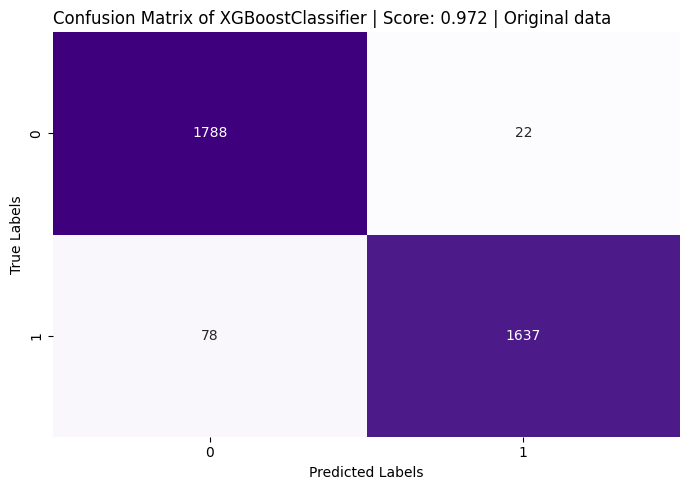

In [49]:
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, cbar=False, fmt="d", cmap="Purples")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title(f"Confusion Matrix of {model["model_name"]} | Score: {np.round(acc_score, 3)} | {model["data_type"]}", loc="left")
plt.tight_layout()
plt.show();

In [50]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

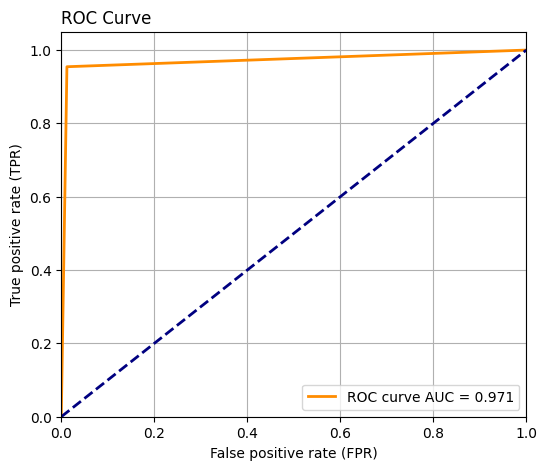

In [51]:
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve AUC = {np.round(roc_auc, 3)}")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.title('ROC Curve', loc="left")
plt.legend(loc="lower right")
plt.grid()
plt.show()